In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

60000개의 손글씨 데이타를 준비하는 과정입니다.

In [34]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#x_train을 살펴보자. 28x28 사이즈를 가진 60000개의 이미지들입니다.
#y_train을 살펴보자. 60000개의 숫자라벨입니다.
x_train.shape , y_train.shape

((60000, 28, 28), (60000,))

In [37]:
#0~255컬러값을 0~1.0 값으로 변환
x_train, x_test = x_train / 255.0, x_test / 255.0

# 채널 차원을 추가합니다. 이미지가 Gray Scale이기 때문에.. 한 차수 증가
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

x_train.shape

(60000, 28, 28, 1)

In [6]:
#tf.data를 사용하여 데이터셋을 섞고 배치를 만듭니다:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

### 학습 모델을 구성한다.
1. 신경망 학습에 모델을 넣기 전에, 모델의 가진 특징(Feature)를 추출하는 작업
2. 이를 Fully Connected로 연결하는 작업

In [30]:
class MyModel(Model):
    
  def __init__(self):
    super(MyModel, self).__init__()
    
    ## 이 부분이 딥러닝 학습 구조(노드들을)를 배치하는 과정입니다.
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    
    # Features Extraction Layers
    
    ## 입력된 이미지를 먼저 Conv2D 노드에 넣어서 가공하고
    x = self.conv1(x)
    ## 그 결과를 Flatten 노드에 넣어서 다시 가공하고
    x = self.flatten(x)
    
    # FullyConnected Layers 
    
    ## 그 결과를 Dense에 넣어 Fully Connected
    x = self.d1(x)
    ## 마지막으로 softmax 알고리즘에 넣어서 확률로 결과값 표현
    return self.d2(x)

model = MyModel()

### Loss Function 정의 /모델을 평가하는 부분

In [32]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [39]:
#값들의 평균을 내서, Loss 값으로 사용 
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### 옵티마이징 정의
1. SGD/Adam/RMSprop 등이 있음

In [31]:
optimizer = tf.keras.optimizers.Adam()

학습 시작
   1. Feature Extraction > Fully Connected
   2. Loss 평가 > Optimize
   3. 다시 1로 

In [40]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    #모델을 통해 예측값 획득
    predictions = model(images)
    loss = loss_object(labels, predictions)
    
  #옵타마이징을 위한 기울기(최적화 방향)를 받아 온다
  gradients = tape.gradient(loss, model.trainable_variables)
  #옵티마이지 펑션에 기울기를 반영
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [14]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

### 지금 부터 학습을 시작합니다.

In [16]:
#에포크는 동일한 데이타셋을 몇번 반복해서 학습을 시킬것인지를 의미합니다.
#앞에서 나온 배치는 60000만개의 데이타를 학습에 밀어 넣을때, 몇개를 묶어서 넣을 것이냐를 의미합니다.
EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

에포크: 1, 손실: 0.11711452901363373, 정확도: 96.42730712890625, 테스트 손실: 0.05759671330451965, 테스트 정확도: 98.11000061035156
에포크: 2, 손실: 0.08026456832885742, 정확도: 97.54838562011719, 테스트 손실: 0.05866595357656479, 테스트 정확도: 98.125
에포크: 3, 손실: 0.060736510902643204, 정확도: 98.1514892578125, 테스트 손실: 0.06111077964305878, 테스트 정확도: 98.0633316040039
에포크: 4, 손실: 0.048985905945301056, 정확도: 98.50094604492188, 테스트 손실: 0.06149331107735634, 테스트 정확도: 98.10749816894531
에포크: 5, 손실: 0.04154147952795029, 정확도: 98.72156524658203, 테스트 손실: 0.06251738220453262, 테스트 정확도: 98.13800048828125


## 사용

In [43]:
test_image = x_test[0,:,:,0]
pred = model.predict(test_image.reshape(1,28,28,1))
pred

array([[0.10296176, 0.1024738 , 0.08738489, 0.09359147, 0.09476233,
        0.10831702, 0.10840954, 0.09938325, 0.10476246, 0.09795345]],
      dtype=float32)

In [44]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


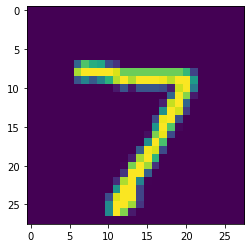

In [45]:
plt.imshow(test_image)
plt.show()

In [46]:
np.argmax(pred)

6